In [1]:
!pip install SimpleITK
!pip install dipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import SimpleITK as sitk
import tensorflow.keras.datasets.mnist as mnist
import random
from numpy.random import uniform
import os
import cv2
import math
from dipy.utils.optpkg import optional_package
from distutils.version import LooseVersion
import tqdm.notebook as tqdm


In [3]:
tf, have_tf, _ = optional_package('tensorflow')
layers, _, _ = optional_package("tensorflow.keras.layers")
matplotlib, has_mpl, setup_module = optional_package("matplotlib")
plt, _, _ = optional_package("matplotlib.pyplot")

if have_tf:
    if LooseVersion(tf.__version__) < LooseVersion('2.0.0'):
        raise ImportError('Please upgrade to TensorFlow 2+')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [4]:
class Args():
    train_size = 4000
    test_size = 400
    batch_size = 512
    epochs = 2000
    lr = 0.01
    num_samples = 5  # number of sample results to show
    save_model = 0
    sample_count = 5

args = Args()

In [5]:
def plot_images(moving, static, moved):
    nb, nh, nw, nc = moving.shape

    # Convert the tensors to 8-bit images.
    moved = moved.numpy().squeeze(axis=-1) * 255.0
    moved = moved.astype(np.uint8)
    moving = moving.numpy().squeeze(axis=-1) * 255.0
    moving = moving.astype(np.uint8)
    static = static.numpy().squeeze(axis=-1) * 255.0
    static = static.astype(np.uint8)

    # Plot images.
    fig = plt.figure(figsize=(3 * 1.7, nb * 1.7))
    titles_list = ['Static', 'Moved', 'Moving']
    images_list = [static, moved, moving]
    for i in range(nb):
        for j in range(3):
            ax = fig.add_subplot(nb, 3, i * 3 + j + 1)
            if i == 0:
                ax.set_title(titles_list[j], fontsize=20)
            ax.set_axis_off()
            ax.imshow(images_list[j][i], cmap='gray')

    plt.tight_layout()
    plt.show()

image transform helper functions

In [6]:
def regular_grid_2d(height, width):
    x = tf.linspace(-1.0, 1.0, width)  # shape (W, )
    y = tf.linspace(-1.0, 1.0, height)  # shape (H, )

    X, Y = tf.meshgrid(x, y)  # shape (H, W), both X and Y

    grid = tf.stack([X, Y], axis=-1)
    return grid

In [7]:
def grid_transform(theta, grid):
    # todo grid has nb
    nb = tf.shape(theta)[0]
    nh, nw, _ = tf.shape(grid)
    x = grid[..., 0]  # h,w
    y = grid[..., 1]

    x_flat = tf.reshape(x, shape=[-1])
    y_flat = tf.reshape(y, shape=[-1])
    ones = tf.ones_like(x_flat)
    grid_flat = tf.stack([x_flat, y_flat, ones])
    grid_flat = tf.expand_dims(grid_flat, axis=0)

    grid_flat = tf.tile(grid_flat, tf.stack([nb, 1, 1]))  # (None, 3, 1024)

    theta = tf.cast(theta, 'float32')
    grid_flat = tf.cast(grid_flat, 'float32')

    grid_new = tf.matmul(theta, grid_flat)  # n, 2, h*w // (None, 2, 1024)

    grid_new = tf.transpose(grid_new, perm=[0, 2, 1])  # (None, 1024, 2)

    grid_new = tf.reshape(grid_new, [nb, nh, nw, 2])  # (None, 32, 32, 2)

    return grid_new


In [8]:
def grid_sample_2d(moving, grid):
    nb, nh, nw, nc = tf.shape(moving)

    x = grid[..., 0]  # shape (N, H, W)
    y = grid[..., 1]
    x = tf.cast(x, 'float32')
    y = tf.cast(y, 'float32')

    # Scale x and y from [-1.0, 1.0] to [0, W] and [0, H] respectively.
    x = (x + 1.0) * 0.5 * tf.cast(nw - 1, 'float32')
    y = (y + 1.0) * 0.5 * tf.cast(nh - 1, 'float32')

    y_max = tf.cast(nh - 1, 'int32')
    x_max = tf.cast(nw - 1, 'int32')
    zero = tf.constant(0, 'int32')

    # The value at (x, y) is a weighted average of the values at the
    # four nearest integer locations: (x0, y0), (x1, y0), (x0, y1) and
    # (x1, y1) where x0 = floor(x), x1 = ceil(x).
    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1

    # Make sure indices are within the boundaries of the image.
    x0 = tf.clip_by_value(x0, zero, x_max)
    x1 = tf.clip_by_value(x1, zero, x_max)
    y0 = tf.clip_by_value(y0, zero, y_max)
    y1 = tf.clip_by_value(y1, zero, y_max)

    # Collect indices of the four corners.
    b = tf.ones_like(x0) * tf.reshape(tf.range(nb), [nb, 1, 1])
    idx_a = tf.stack([b, y0, x0], axis=-1)  # all top-left corners
    idx_b = tf.stack([b, y1, x0], axis=-1)  # all bottom-left corners
    idx_c = tf.stack([b, y0, x1], axis=-1)  # all top-right corners
    idx_d = tf.stack([b, y1, x1], axis=-1)  # all bottom-right corners
    # shape (N, H, W, 3)

    # Collect values at the corners.
    moving_a = tf.gather_nd(moving, idx_a)  # all top-left values
    moving_b = tf.gather_nd(moving, idx_b)  # all bottom-left values
    moving_c = tf.gather_nd(moving, idx_c)  # all top-right values
    moving_d = tf.gather_nd(moving, idx_d)  # all bottom-right values
    # shape (N, H, W, C)

    x0_f = tf.cast(x0, 'float32')
    x1_f = tf.cast(x1, 'float32')
    y0_f = tf.cast(y0, 'float32')
    y1_f = tf.cast(y1, 'float32')

    # Calculate the weights.
    wa = tf.expand_dims((x1_f - x) * (y1_f - y), axis=-1)
    wb = tf.expand_dims((x1_f - x) * (y - y0_f), axis=-1)
    wc = tf.expand_dims((x - x0_f) * (y1_f - y), axis=-1)
    wd = tf.expand_dims((x - x0_f) * (y - y0_f), axis=-1)

    # Calculate the weighted sum.
    moved = tf.add_n([wa * moving_a, wb * moving_b, wc * moving_c, wd * moving_d])
    return moved


In [9]:
def do_affine_2d(matrix, moving):
  grid = regular_grid_2d(32, 32)
  grid_new = grid_transform(matrix, grid)
  grid_new = tf.clip_by_value(grid_new, -1, 1)
  moved = grid_sample_2d(moving, grid_new)
  return moved

data creator

In [10]:
def load_data(train_count=1000, test_count=100):
    """Loads the MNIST dataset and preprocesses it: scales to [0.0, 1.0]
    range, resizes the images from (28, 28) to (32, 32) and filters the
    dataset to keep images of just one class.


    Returns
    -------
    (x_train, x_test) : tuple of ndarrays
        NumPy arrays of training and testing images.
    """
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    x_train = x_train[:train_count]
    x_test = x_test[:test_count]

    # Scale the image to [0, 1] range.
    x_train = x_train.astype(np.float32) / 255.0
    x_test = x_test.astype(np.float32) / 255.0

    # Add the channel dim at the end. (N, H, W) --> (N, H, W, 1)
    x_train = x_train[..., None]
    x_test = x_test[..., None]

    # Resize images from (28, 28) to (32, 32).
    x_train = tf.image.resize(x_train, (32, 32))
    x_test = tf.image.resize(x_test, (32, 32))
    return x_train, x_test

function to create random affine matrix

In [11]:
def rand_min_plos_1():
    return (random.randint(0, 1) - 0.5) * 2

def generate_aff_matrices(dim, num, max_scaling=0.5, max_translation=0, max_shear=1, set_max=0):
    matrices = []
    for _ in range(num):
        mat = np.eye(dim + 1)
        for i in range(dim):
            for j in range(dim):
                if i == j:  # scaling
                    mat[i][j] *= (1 + rand_min_plos_1() * max_scaling) if set_max else uniform(1 - max_scaling,
                                                                                               1 + max_scaling)
                else:  # shear
                    mat[i][j] += rand_min_plos_1() * max_shear if set_max else uniform(-max_shear, max_shear)

            mat[i][dim] += rand_min_plos_1() * max_translation if set_max else uniform(-max_translation,
                                                                                       max_translation)
        mat = mat[0:dim, 0:dim + 1]
        matrices.append(mat)
    return matrices


The cnn model

In [12]:
def simple_cnn(input_shape=(32, 32)):
    in_channels = 1
    # out_channels = 3
    input_shape = input_shape + (in_channels,)
    moving = layers.Input(shape=input_shape, name='moving')
    static = layers.Input(shape=input_shape, name='static')
    x_in = layers.concatenate([static, moving], axis=-1)
    # print(input_shape)
    x = x_in

    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same',
                      activation='relu')(x)  # 32 --> 16
    x = layers.BatchNormalization()(x)  # 16
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)  # 16
    x = layers.BatchNormalization()(x)  # 16
    x = layers.MaxPool2D(pool_size=2)(x)  # 16 --> 8
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)  # 8
    x = layers.BatchNormalization()(x)  # 8
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)  # 8
    x = layers.BatchNormalization()(x)  # 8
    x = layers.MaxPool2D(pool_size=2)(x)  # 8 --> 4
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same',
                      activation='relu')(x)  # 4
    x = layers.BatchNormalization()(x)  # 4

    x = layers.Flatten()(x)

    x = layers.Dense(32, activation='relu')(x)  # 4*4*32

    start_matrix = [1, 0, 0,
                    0, 1, 0]

    x = layers.Dense(6, kernel_initializer='zeros',
                     bias_initializer=tf.constant_initializer(start_matrix))(x)
    nb, _ = tf.shape(x)
    theta = tf.reshape(x, [nb, 2, 3])
    grid = regular_grid_2d(32, 32)
    grid_new = grid_transform(theta, grid)
    grid_new = tf.clip_by_value(grid_new, -1, 1)

    moved = grid_sample_2d(static, grid_new)

    model = tf.keras.Model(inputs=[static, moving], outputs=[moved, theta],
                           name='simple_cnn')
    return model

train, test and loss functions

In [13]:
# @tf.function
def mse_loss(static, moving):
    loss = tf.reduce_mean(tf.square(moving - static))  # shape ()
    return loss


# @tf.function
def ncc_loss(static, moving):
    eps = tf.constant(1e-9, 'float32')

    static_mean = tf.reduce_mean(static, axis=[1, 2], keepdims=True)
    moving_mean = tf.reduce_mean(moving, axis=[1, 2], keepdims=True)
    # shape (N, 1, 1, C)

    static_std = tf.math.reduce_std(static, axis=[1, 2], keepdims=True)
    moving_std = tf.math.reduce_std(moving, axis=[1, 2], keepdims=True)
    # shape (N, 1, 1, C)

    static_hat = (static - static_mean)/(static_std + eps)
    moving_hat = (moving - moving_mean)/(moving_std + eps)
    # shape (N, H, W, C)

    ncc = tf.reduce_mean(static_hat * moving_hat)  # shape ()
    loss = -ncc
    return loss

In [14]:
# @tf.function
def train_step(model, moving, static, criterion, optimizer):
    nb, nh, nw, nc = tf.keras.backend.int_shape(moving)  # moving.shape

    # Repeat the static image along the batch dim.
    multiples = tf.constant([nb, 1, 1, 1], tf.int32)

    # Define the GradientTape context for automatic differentiation.
    with tf.GradientTape() as tape:
        # Get the deformation field
        # inputs = tf.concat([moving, static], axis=-1)
        # print(static.shape)
        # print(moving.shape)
        moved, matrix = model({'moving': moving, 'static': static})
        # Compute the loss.
        loss = criterion(moved, moving)

    # Compute gradients.
    grads = tape.gradient(loss, model.trainable_variables)
    # Update the trainable parameters.
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [15]:
# @tf.function
def test_step(model, moving, static, criterion):
    nb, nh, nw, nc = tf.keras.backend.int_shape(moving)  # moving.shape

    # Repeat the static image along the batch dim.
    multiples = tf.constant([nb, 1, 1, 1], tf.int32)

    # Get the deformation field.
    # inputs = tf.concat([moving, static], axis=-1)
    moved, matrix = model({'moving': moving, 'static': static}, training=False)

    # Compute the loss.
    loss = criterion(moved, moving)
    return loss

In [16]:
random.seed(42)
np.random.seed(42)

train_size = args.train_size
test_size = args.test_size
train_static_all, test_static_all = load_data(train_size, test_size)

train_affine_matrices = generate_aff_matrices(dim=2, num=train_static_all.shape[0])
test_affine_matrices = generate_aff_matrices(dim=2, num=test_static_all.shape[0])

train_moving_all = do_affine_2d(train_affine_matrices, train_static_all)
test_moving_all = do_affine_2d(test_affine_matrices, test_static_all)

samples_static = test_static_all[0:args.sample_count]
samples_moving = test_moving_all[0:args.sample_count]
samples_matrices = test_affine_matrices[0:args.sample_count]

from_tensor_slices = tf.data.Dataset.from_tensor_slices
train_moving = from_tensor_slices(train_moving_all).shuffle(10000).batch(args.batch_size)
train_static = from_tensor_slices(train_static_all).shuffle(10000).batch(args.batch_size)
test_moving = from_tensor_slices(test_moving_all).shuffle(10000).batch(args.batch_size)
test_static = from_tensor_slices(test_static_all).shuffle(10000).batch(args.batch_size)

In [17]:
# Create a model instance.
model = simple_cnn(input_shape=(32, 32))

# Select optimizer and loss function.
optimizer = tf.keras.optimizers.SGD(learning_rate=args.lr)
criterion = ncc_loss  # or mse_loss

# Define the metrics to track training and testing losses.
m_train = tf.keras.metrics.Mean(name='loss_train')
m_test = tf.keras.metrics.Mean(name='loss_test')

test_losses = []
train_losses = []

best_test_score = 0

# Train and evaluate the model.
with tqdm.trange(args.epochs) as pbar:
  for epoch in pbar:
      m_train.reset_states()
      m_test.reset_states()
      for i, (moving, static) in enumerate(zip(train_moving, train_static)):
          loss_train = train_step(model, moving, static, criterion, optimizer)
          m_train.update_state(loss_train)

      for i, (moving, static) in enumerate(zip(test_moving, test_static)):
          loss_test = test_step(model, moving, static, criterion)
          m_test.update_state(loss_test)
      train_losses.append(m_train.result())
      test_losses.append(m_test.result())

      if best_test_score > test_losses[-1]+0.01:
        best_test_score = test_losses[-1]
        if args.save_model:
          # print(f'model saved with loss = {best_test_score}')
          model.save('saved_models/simple_cnn')
      pbar.set_description("TrainLoss={:.2f}, TestLoss={:.2f}, BestTestLoss={:.2f}".format(m_train.result(), m_test.result(), best_test_score))
print('\n')

# # Show sample results.
# plot_images(model, x_sample, static)

# Save the trained model.


  0%|          | 0/2000 [00:00<?, ?it/s]

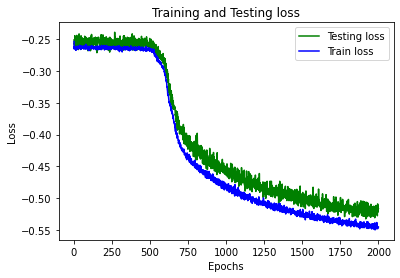

In [18]:
epochs = range(1, args.epochs+1)
plt.plot(epochs, test_losses, 'g', label='Testing loss')
plt.plot(epochs, train_losses, 'b', label='Train loss')
plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Example from the tests

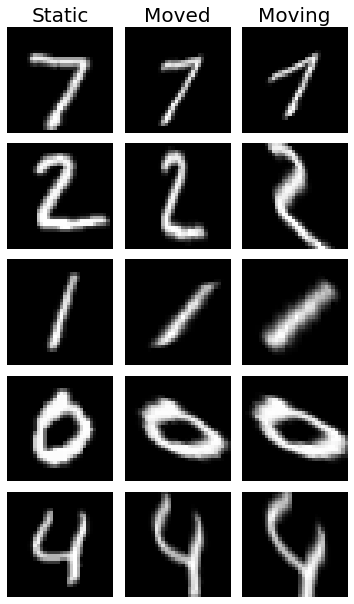

1) expected_matrix - model_matrix = 
[[-0.33640957 -0.36533538  0.0313728 ]
 [ 0.5271994   0.2771243   0.01269852]]
diff norm = 0.7762241363525391
ncc=0.2250075489282608
2) expected_matrix - model_matrix = 
[[-0.522923   -0.11479387 -0.0412444 ]
 [-0.67116934  0.08039981  0.06218388]]
diff norm = 0.8655208945274353
ncc=0.5214778184890747
3) expected_matrix - model_matrix = 
[[-0.01870853  0.11201596  0.01938471]
 [-0.8607749  -0.76301736  0.12479083]]
diff norm = 1.1627446413040161
ncc=0.1747347116470337
4) expected_matrix - model_matrix = 
[[-0.03067565 -0.2434848  -0.00177264]
 [ 0.13551402 -0.04873431  0.01696662]]
diff norm = 0.2850542664527893
ncc=0.06745412200689316
5) expected_matrix - model_matrix = 
[[-0.20919508  0.14327231  0.02586928]
 [-0.25959092 -0.12628913 -0.04570905]]
diff norm = 0.3877943456172943
ncc=0.32910794019699097


In [19]:
def plot_results(samples_static=samples_static, samples_moving=samples_moving):
  moved, matrix = model({'moving': samples_moving, 'static': samples_static}, training=False)
  plot_images(samples_moving, samples_static, moved)

  for i in range(len(matrix)):
    m1 = samples_matrices[i]
    m2 = matrix[i]
    # print(f'expected_matrix=\n{m1}')
    # print(f'model_matrix=\n{m2}')
    print(f'{i+1}) expected_matrix - model_matrix = \n{np.array(m1 - m2)}\ndiff norm = {np.linalg.norm(np.array(m1 - m2))}')
    print(f'ncc={-ncc_loss(samples_moving[i], samples_static[i]).numpy()}')
    print(f'========================================================')

plot_results()

In [20]:
nccs = []
diffs = []
train_moved_all, out_matrix = model({'moving': test_static_all, 'static': test_static_all}, training=False)
for i in range(len(test_static_all)):
  static = test_static_all[i]
  moving = test_static_all[i]
  m1 = train_affine_matrices[i]
  m2 = out_matrix[i]
  moved = train_moved_all[i]
  diffs.append(np.linalg.norm(np.array(m1 - m2)))
  nccs.append(-ncc_loss(moving, moved).numpy())

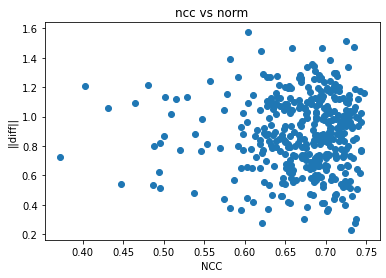

In [21]:
plt.scatter(nccs, diffs)
plt.title('ncc vs norm')
plt.xlabel('NCC')
plt.ylabel('||diff||')
plt.show()